In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torch.utils.data import random_split
from torchvision import datasets 
from torchvision import transforms 
from torch.utils.data import Dataset
import glob
from PIL import Image 
import cv2
import pandas as pd
import albumentations as A 
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torchvision.models as models
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# !pip install kaggle
# from google.colab import files
# files.upload() 

# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d ammaralfaifi/5class-weather-status-image-classification
# !unzip -q 5class-weather-status-image-classification.zip -d weather

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/













Saving kaggle.json to kaggle.json


 98% 489M/498M [00:06<00:00, 98.5MB/s]

100% 498M/498M [00:06<00:00, 81.1MB/s]


### 전처리

In [7]:
root = '/kaggle/input/5class-weather-status-image-classification/data/'
#root = './weather/data/'
labels_map = {0:'cloudy', 1:'foggy', 2:'rainy', 3:'snowy', 4:'sunny'}

transform = A.Compose([A.Resize(224,224),
                       A.Normalize(),
                       A.VerticalFlip(p=0.3), 
                       A.HorizontalFlip(p=0.3),
                       A.Rotate(limit=(0, 40), p=0.3, border_mode=cv2.BORDER_CONSTANT),
                       ToTensorV2()])

mydata = mysetting(root, labels_map)
mydata.getDataset(transform, using='A')

train, valid, test: 11728 2705 3606


In [15]:
batch_s = 32
mydata.getDataloader(batch_s)

train, valid, test: 367 85 113
trainloader shape torch.Size([32, 3, 224, 224]) torch.Size([32])


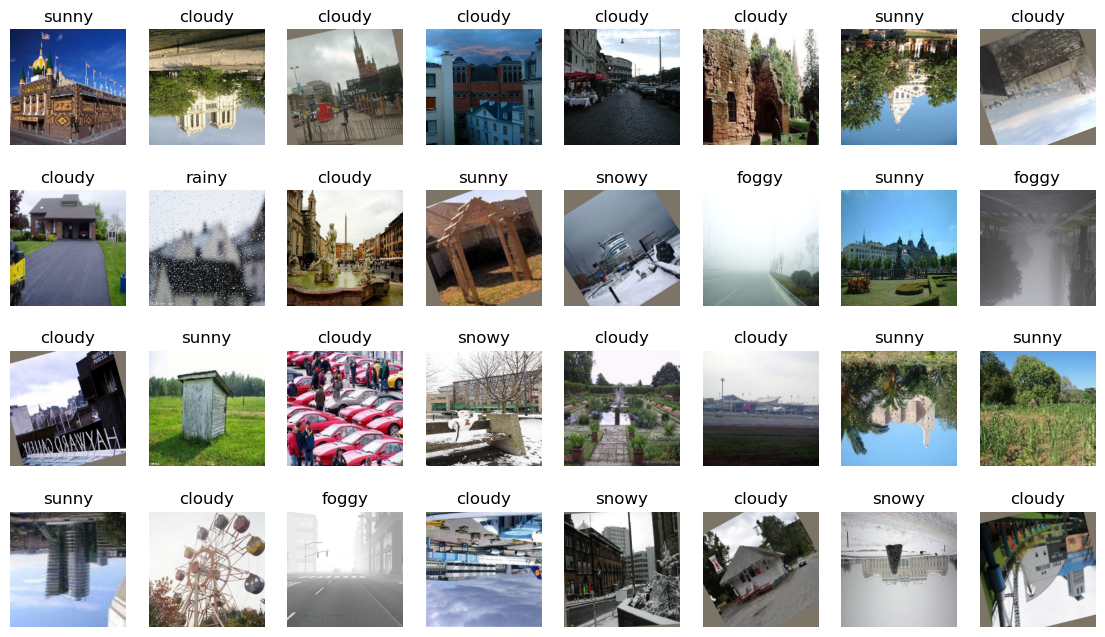

In [9]:
mydata.showimg()

### model 설정 

In [10]:
# https://github.com/pytorch/vision/tree/6db1569c89094cf23f3bc41f79275c45e9fcb3f3/torchvision/models
model = models.resnet34(weights=True)

for parameter in model.parameters():
    parameter.requires_grad = False 
for parameter in model.fc.parameters(): # classifier bolck: fc
    parameter.requires_grad = True 
model.fc = nn.Sequential(
                    nn.Linear(512,256),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(256,5))
model.fc

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Sequential(
  (0): Linear(in_features=512, out_features=256, bias=True)
  (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=256, out_features=5, bias=True)
)

In [11]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# resnet34, lr=0.001, batch_s=16, scheduler=ReduceLROnPlateau

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch : 1/55....... Train Loss : 0.790 Valid Loss : 0.612 Valid Accuracy : 0.753
Epoch : 2/55....... Train Loss : 0.683 Valid Loss : 0.597 Valid Accuracy : 0.761
Epoch : 3/55....... Train Loss : 0.636 Valid Loss : 0.564 Valid Accuracy : 0.769
Epoch : 4/55....... Train Loss : 0.606 Valid Loss : 0.586 Valid Accuracy : 0.754
Epoch : 5/55....... Train Loss : 0.607 Valid Loss : 0.534 Valid Accuracy : 0.776
Epoch : 6/55....... Train Loss : 0.592 Valid Loss : 0.533 Valid Accuracy : 0.779
Epoch : 7/55....... Train Loss : 0.574 Valid Loss : 0.540 Valid Accuracy : 0.785
Epoch : 8/55....... Train Loss : 0.569 Valid Loss : 0.514 Valid Accuracy : 0.788
Epoch : 9/55....... Train Loss : 0.561 Valid Loss : 0.519 Valid Accuracy : 0.790
Epoch : 10/55....... Train Loss : 0.548 Valid Loss : 0.536 Valid Accuracy : 0.787
Epoch : 11/55....... Train Loss : 0.547 Valid Loss : 0.545 Valid Accuracy : 0.793
Epoch : 12/55....... Train Loss : 0.541 Valid Loss : 0.520 Valid Accuracy : 0.794
Epoch : 13/55....... Trai

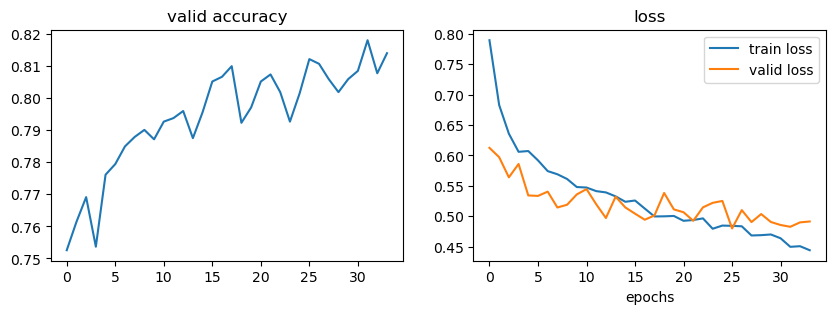

test loss: 0.482
test accuracy: 0.812
test loss: 0.485
test accuracy: 0.814
test loss: 0.503
test accuracy: 0.803


In [13]:
model = models.resnet34(weights=True)
for parameter in model.parameters():
    parameter.requires_grad = False 
for parameter in model.fc.parameters():
    parameter.requires_grad = True 
model.fc = nn.Sequential(
                    nn.Linear(512,256),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(256,5))
lr = 0.001; patience = 7; epochs = 55
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience = 4, verbose = True)
myNN = train(model, loss_fn, optimizer, mydata.trainloader, mydata.validloader, mydata.testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN.train_loop()
myNN.result_plot()
# myNN.check(unsq=True, rnd_idx=10)
myNN.evaluation(myNN.model, myNN.testloader, myNN.loss_fn)
torch.save(myNN.model.state_dict(), 'last_checkpoint.pth')
myNN.load_model(dirct='last_checkpoint.pth', model=model)
myNN.load_model(dirct='best_checkpoint.pth', model=model)

# resnet34, lr=0.0001, batch_s=16, scheduler=ReduceLROnPlateau

Epoch : 1/55....... Train Loss : 1.015 Valid Loss : 0.770 Valid Accuracy : 0.717
Epoch : 2/55....... Train Loss : 0.761 Valid Loss : 0.664 Valid Accuracy : 0.738
Epoch : 3/55....... Train Loss : 0.701 Valid Loss : 0.631 Valid Accuracy : 0.751
Epoch : 4/55....... Train Loss : 0.663 Valid Loss : 0.613 Valid Accuracy : 0.747
Epoch : 5/55....... Train Loss : 0.648 Valid Loss : 0.579 Valid Accuracy : 0.761
Epoch : 6/55....... Train Loss : 0.640 Valid Loss : 0.578 Valid Accuracy : 0.770
Epoch : 7/55....... Train Loss : 0.621 Valid Loss : 0.587 Valid Accuracy : 0.763
Epoch : 8/55....... Train Loss : 0.606 Valid Loss : 0.580 Valid Accuracy : 0.760
Epoch : 9/55....... Train Loss : 0.600 Valid Loss : 0.570 Valid Accuracy : 0.773
Epoch : 10/55....... Train Loss : 0.589 Valid Loss : 0.539 Valid Accuracy : 0.792
Epoch : 11/55....... Train Loss : 0.574 Valid Loss : 0.532 Valid Accuracy : 0.783
Epoch : 12/55....... Train Loss : 0.570 Valid Loss : 0.530 Valid Accuracy : 0.792
Epoch : 13/55....... Trai

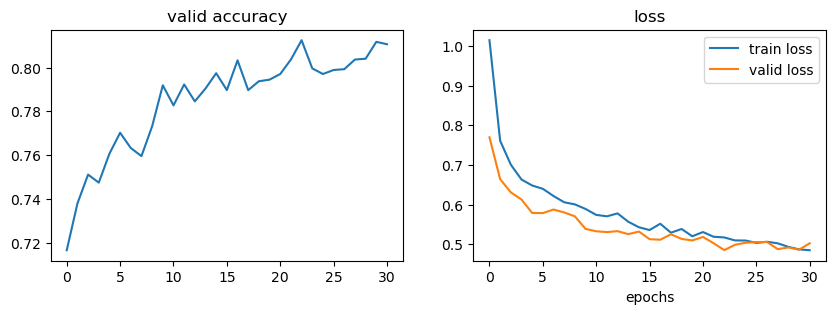

test loss: 0.509
test accuracy: 0.791
test loss: 0.498
test accuracy: 0.797
test loss: 0.506
test accuracy: 0.798


In [14]:
model = models.resnet34(weights=True)
for parameter in model.parameters():
    parameter.requires_grad = False 
for parameter in model.fc.parameters():
    parameter.requires_grad = True 
model.fc = nn.Sequential(
                    nn.Linear(512,256),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(256,5))
lr = 0.0001; patience = 7; epochs = 55
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience = 4, verbose = True)
myNN = train(model, loss_fn, optimizer, mydata.trainloader, mydata.validloader, mydata.testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN.train_loop()
myNN.result_plot()
# myNN.check(unsq=True, rnd_idx=10)
myNN.evaluation(myNN.model, myNN.testloader, myNN.loss_fn)
torch.save(myNN.model.state_dict(), 'last_checkpoint.pth')
myNN.load_model(dirct='last_checkpoint.pth', model=model)
myNN.load_model(dirct='best_checkpoint.pth', model=model)

# resnet34, lr=0.001, batch_s=32, scheduler=ReduceLROnPlateau

Epoch : 1/55....... Train Loss : 0.769 Valid Loss : 0.629 Valid Accuracy : 0.745
Epoch : 2/55....... Train Loss : 0.627 Valid Loss : 0.594 Valid Accuracy : 0.754
Epoch : 3/55....... Train Loss : 0.587 Valid Loss : 0.557 Valid Accuracy : 0.781
Epoch : 4/55....... Train Loss : 0.561 Valid Loss : 0.535 Valid Accuracy : 0.776
Epoch : 5/55....... Train Loss : 0.552 Valid Loss : 0.535 Valid Accuracy : 0.784
Epoch : 6/55....... Train Loss : 0.530 Valid Loss : 0.542 Valid Accuracy : 0.779
Epoch : 7/55....... Train Loss : 0.513 Valid Loss : 0.550 Valid Accuracy : 0.779
Epoch : 8/55....... Train Loss : 0.512 Valid Loss : 0.534 Valid Accuracy : 0.788
Epoch : 9/55....... Train Loss : 0.504 Valid Loss : 0.537 Valid Accuracy : 0.794
Epoch : 10/55....... Train Loss : 0.493 Valid Loss : 0.510 Valid Accuracy : 0.795
Epoch : 11/55....... Train Loss : 0.485 Valid Loss : 0.521 Valid Accuracy : 0.793
Epoch : 12/55....... Train Loss : 0.473 Valid Loss : 0.511 Valid Accuracy : 0.808
Epoch : 13/55....... Trai

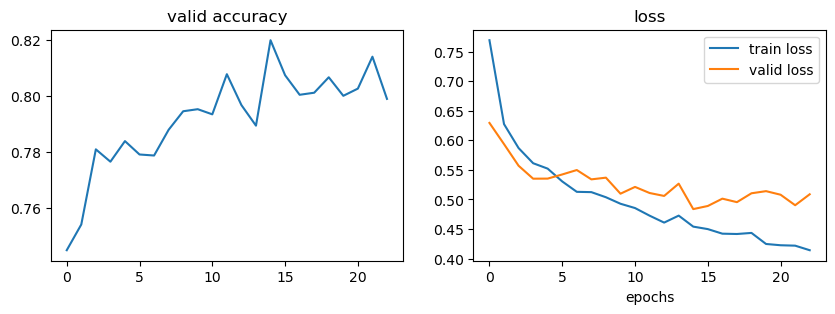

test loss: 0.520
test accuracy: 0.797
test loss: 0.526
test accuracy: 0.795
test loss: 0.520
test accuracy: 0.791


In [ ]:
model = models.resnet34(weights=True)
for parameter in model.parameters():
    parameter.requires_grad = False 
for parameter in model.fc.parameters():
    parameter.requires_grad = True 
model.fc = nn.Sequential(
                    nn.Linear(512,256),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(256,5))
lr = 0.001; patience = 7; epochs = 55
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience = 4, verbose = True)
myNN = train(model, loss_fn, optimizer, mydata.trainloader, mydata.validloader, mydata.testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN.train_loop()
myNN.result_plot()
# myNN.check(unsq=True, rnd_idx=10)
myNN.evaluation(myNN.model, myNN.testloader, myNN.loss_fn)
torch.save(myNN.model.state_dict(), 'last_checkpoint.pth')
myNN.load_model(dirct='last_checkpoint.pth', model=model)
myNN.load_model(dirct='best_checkpoint.pth', model=model)

# resnet34, lr = 0.0001, batch_s=32, scheduler=ReduceLROnPlateau

Epoch : 1/55....... Train Loss : 0.804 Valid Loss : 0.612 Valid Accuracy : 0.753

Epoch : 2/55....... Train Loss : 0.674 Valid Loss : 0.584 Valid Accuracy : 0.760

Epoch : 3/55....... Train Loss : 0.648 Valid Loss : 0.573 Valid Accuracy : 0.773

Epoch : 4/55....... Train Loss : 0.619 Valid Loss : 0.553 Valid Accuracy : 0.774

Epoch : 5/55....... Train Loss : 0.604 Valid Loss : 0.542 Valid Accuracy : 0.776

Epoch : 6/55....... Train Loss : 0.583 Valid Loss : 0.548 Valid Accuracy : 0.769

Epoch : 7/55....... Train Loss : 0.585 Valid Loss : 0.542 Valid Accuracy : 0.774

Epoch : 8/55....... Train Loss : 0.555 Valid Loss : 0.533 Valid Accuracy : 0.782

Epoch : 9/55....... Train Loss : 0.563 Valid Loss : 0.507 Valid Accuracy : 0.797

Epoch : 10/55....... Train Loss : 0.551 Valid Loss : 0.507 Valid Accuracy : 0.796

Epoch : 11/55....... Train Loss : 0.546 Valid Loss : 0.536 Valid Accuracy : 0.778

Epoch : 12/55....... Train Loss : 0.540 Valid Loss : 0.520 Valid Accuracy : 0.785

Epoch : 13/55

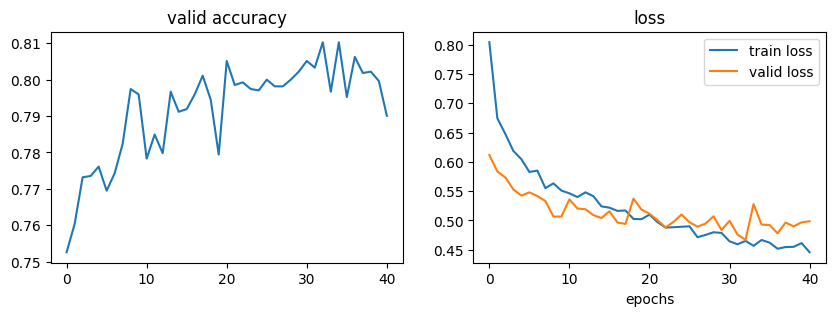

test loss: 0.484

test accuracy: 0.801

test loss: 0.498

test accuracy: 0.804

test loss: 0.490

test accuracy: 0.808


In [ ]:
model = models.resnet34(weights=True)
for parameter in model.parameters():
    parameter.requires_grad = False 
for parameter in model.fc.parameters():
    parameter.requires_grad = True 
model.fc = nn.Sequential(
                    nn.Linear(512,256),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(256,5))
lr = 0.0001; patience = 7; epochs = 55
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience = 4, verbose = True)
myNN = train(model, loss_fn, optimizer, mydata.trainloader, mydata.validloader, mydata.testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN.train_loop()
myNN.result_plot()
# myNN.check(unsq=True, rnd_idx=10)
myNN.evaluation(myNN.model, myNN.testloader, myNN.loss_fn)
torch.save(myNN.model.state_dict(), 'last_checkpoint.pth')
myNN.load_model(dirct='last_checkpoint.pth', model=model)
myNN.load_model(dirct='best_checkpoint.pth', model=model)

# resnet34, lr=0.001, batch_s=32, scheduler=ReduceLROnPlateau

Epoch : 1/55....... Train Loss : 0.768 Valid Loss : 0.632 Valid Accuracy : 0.743
Epoch : 2/55....... Train Loss : 0.636 Valid Loss : 0.601 Valid Accuracy : 0.756
Epoch : 3/55....... Train Loss : 0.589 Valid Loss : 0.585 Valid Accuracy : 0.758
Epoch : 4/55....... Train Loss : 0.563 Valid Loss : 0.557 Valid Accuracy : 0.775
Epoch : 5/55....... Train Loss : 0.548 Valid Loss : 0.529 Valid Accuracy : 0.782
Epoch : 6/55....... Train Loss : 0.527 Valid Loss : 0.531 Valid Accuracy : 0.785
Epoch : 7/55....... Train Loss : 0.515 Valid Loss : 0.524 Valid Accuracy : 0.790
Epoch : 8/55....... Train Loss : 0.504 Valid Loss : 0.537 Valid Accuracy : 0.784
Epoch : 9/55....... Train Loss : 0.497 Valid Loss : 0.497 Valid Accuracy : 0.806
Epoch : 10/55....... Train Loss : 0.492 Valid Loss : 0.527 Valid Accuracy : 0.788
Epoch : 11/55....... Train Loss : 0.485 Valid Loss : 0.498 Valid Accuracy : 0.799
Epoch : 12/55....... Train Loss : 0.479 Valid Loss : 0.507 Valid Accuracy : 0.789
Epoch : 13/55....... Trai

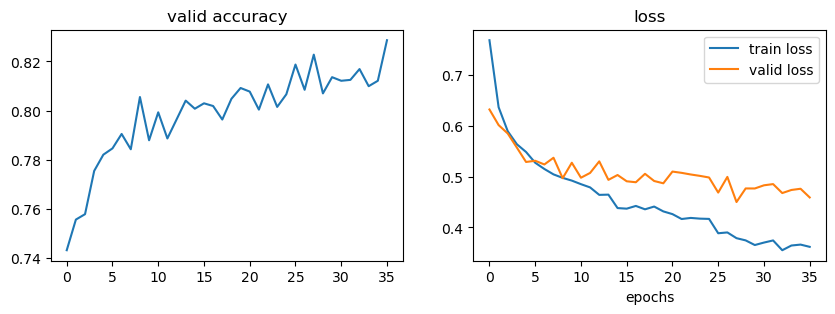

test loss: 0.486
test accuracy: 0.811
test loss: 0.491
test accuracy: 0.802
test loss: 0.493
test accuracy: 0.810


In [17]:
model4 = models.resnet34(weights=True)
for parameter in model4.parameters():
    parameter.requires_grad = False 
for parameter in model4.fc.parameters():
    parameter.requires_grad = True 
model4.fc = nn.Sequential(
                    nn.Linear(512,256),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(256,5))
lr = 0.001; patience = 7; epochs = 55
model4 = model4.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model4.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience = 4, verbose = True)

myNN4 = train(model4, loss_fn, optimizer, mydata.trainloader, mydata.validloader, mydata.testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN4.train_loop()
myNN4.result_plot()
# myNN4.check(unsq=True, rnd_idx=10)
myNN4.evaluation(myNN4.model, myNN4.testloader, myNN4.loss_fn)
torch.save(myNN4.model.state_dict(), 'last_checkpoint.pth')
myNN4.load_model(dirct='last_checkpoint.pth', model=model4)
myNN4.load_model(dirct='best_checkpoint.pth', model=model4)

# resnet34, lr=0.0001, batch_s=32, scheduler=ReduceLROnPlateau

Epoch : 1/55....... Train Loss : 1.100 Valid Loss : 0.828 Valid Accuracy : 0.681
Epoch : 2/55....... Train Loss : 0.791 Valid Loss : 0.718 Valid Accuracy : 0.713
Epoch : 3/55....... Train Loss : 0.705 Valid Loss : 0.662 Valid Accuracy : 0.743
Epoch : 4/55....... Train Loss : 0.665 Valid Loss : 0.620 Valid Accuracy : 0.752
Epoch : 5/55....... Train Loss : 0.637 Valid Loss : 0.610 Valid Accuracy : 0.757
Epoch : 6/55....... Train Loss : 0.610 Valid Loss : 0.582 Valid Accuracy : 0.766
Epoch : 7/55....... Train Loss : 0.601 Valid Loss : 0.580 Valid Accuracy : 0.769
Epoch : 8/55....... Train Loss : 0.583 Valid Loss : 0.574 Valid Accuracy : 0.769
Epoch : 9/55....... Train Loss : 0.572 Valid Loss : 0.564 Valid Accuracy : 0.765
Epoch : 10/55....... Train Loss : 0.557 Valid Loss : 0.570 Valid Accuracy : 0.776
Epoch : 11/55....... Train Loss : 0.547 Valid Loss : 0.547 Valid Accuracy : 0.788
Epoch : 12/55....... Train Loss : 0.538 Valid Loss : 0.542 Valid Accuracy : 0.788
Epoch : 13/55....... Trai

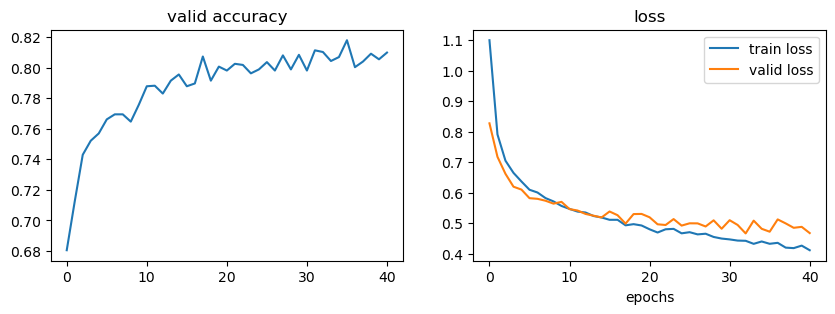

test loss: 0.501
test accuracy: 0.798
test loss: 0.478
test accuracy: 0.808
test loss: 0.503
test accuracy: 0.801


In [18]:
model4 = models.resnet34(weights=True)
for parameter in model4.parameters():
    parameter.requires_grad = False 
for parameter in model4.fc.parameters():
    parameter.requires_grad = True 
model4.fc = nn.Sequential(
                    nn.Linear(512,256),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(256,5))
lr = 0.0001; patience = 7; epochs = 55
model4 = model4.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model4.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience = 4, verbose = True)

myNN4 = train(model4, loss_fn, optimizer, mydata.trainloader, mydata.validloader, mydata.testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN4.train_loop()
myNN4.result_plot()
# myNN4.check(unsq=True, rnd_idx=10)
myNN4.evaluation(myNN4.model, myNN4.testloader, myNN4.loss_fn)
torch.save(myNN4.model.state_dict(), 'last_checkpoint.pth')
myNN4.load_model(dirct='last_checkpoint.pth', model=model4)
myNN4.load_model(dirct='best_checkpoint.pth', model=model4)

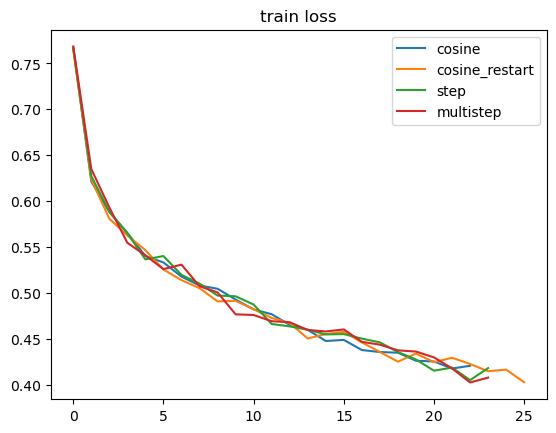

In [ ]:
tl_1, vl_1, va_1 = myNN.train_loss_li, myNN.valid_loss_li, myNN.valid_acc_li
tl_2, vl_2, va_2 = myNN5.train_loss_li, myNN5.valid_loss_li, myNN5.valid_acc_li
tl_3, vl_3, va_3 = myNN3.train_loss_li, myNN3.valid_loss_li, myNN3.valid_acc_li
tl_4, vl_4, va_4 = myNN4.train_loss_li, myNN4.valid_loss_li, myNN4.valid_acc_li

# plot valid acc
def showplot(i, lis, title, sche_names=['cosine','cosine_restart','step','multistep']):
    x_len = max(len(lis[0]), len(lis[1]), len(lis[2]), len(lis[3]))
    for li, sche in zip(lis, sche_names):
        if len(li)<x_len:
            li.extend([None]*(x_len-len(li)))
        plt.plot(np.arange(x_len), li, label=sche)
    plt.title(title)
    plt.legend()

showplot(0, [tl_1, tl_2, tl_3, tl_4], 'train loss')

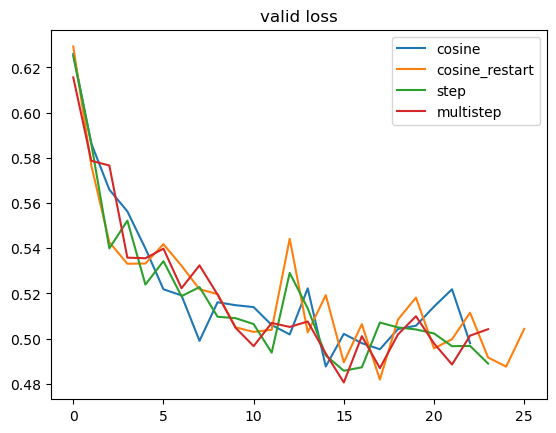

In [ ]:
showplot(1, [vl_1, vl_2, vl_3, vl_4], 'valid loss')

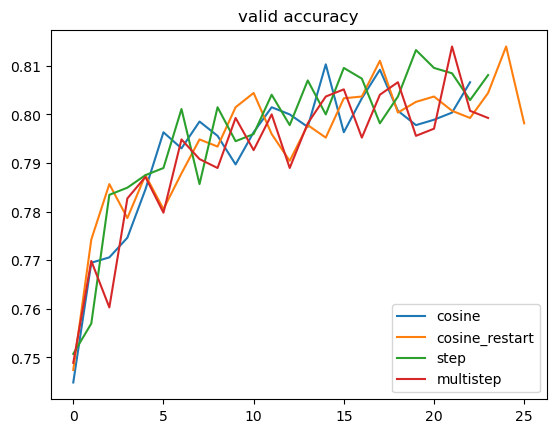

In [ ]:
showplot(2, [va_1, va_2, va_3, va_4], 'valid accuracy')

# lr = 0.001, batch_size = 32 적용한 4가지 스케줄러의 loss 그래프

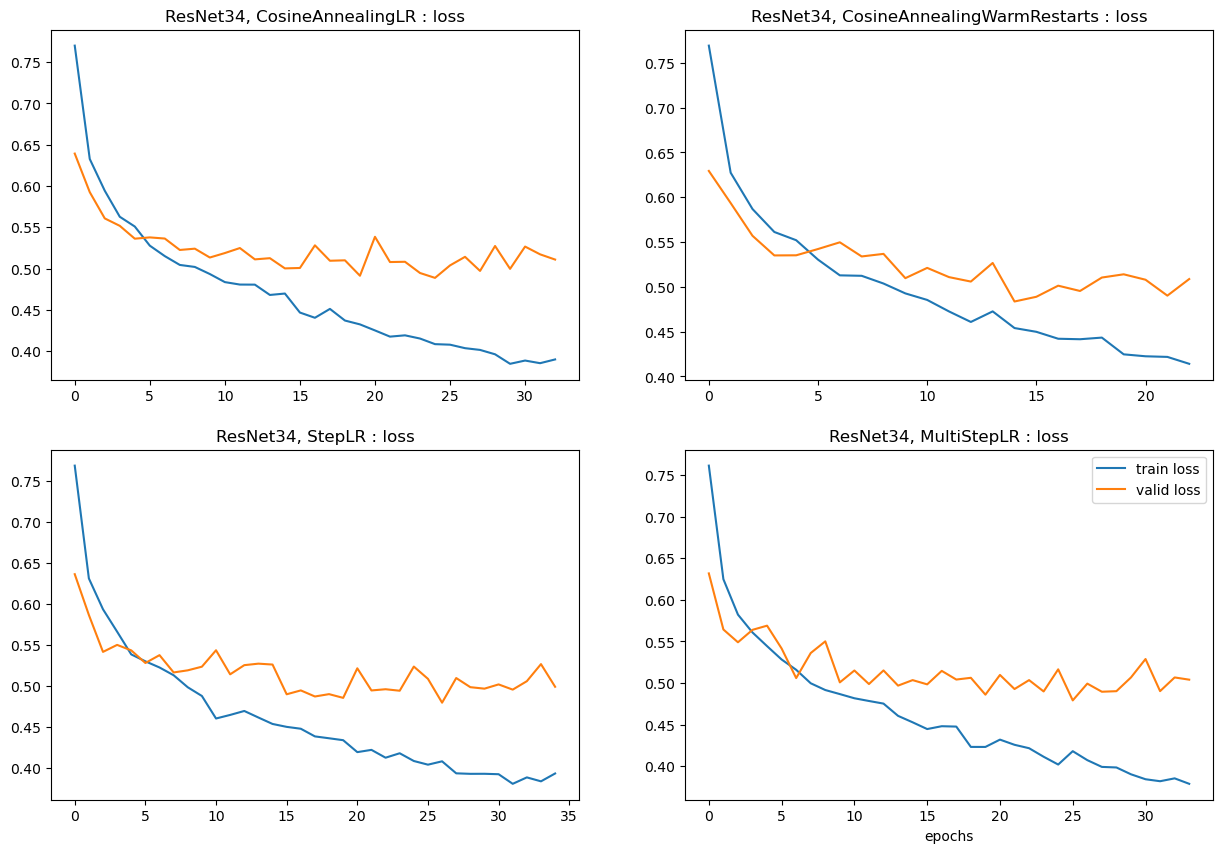

In [ ]:
scheduler_name = {
    0 : "ResNet34, CosineAnnealingLR",
    1 : 'ResNet34, CosineAnnealingWarmRestarts',
    2 : 'ResNet34, StepLR',
    3 : 'ResNet34, MultiStepLR',
}

my_NN = {0 : myNN, 1 : myNN5, 2 : myNN3, 3 : myNN4}

fig, axes = plt.subplots(2,2, figsize = (15, 10))
axes = axes.flatten()
for i in range(4):
    axes[i].plot(np.arange(len(my_NN[i].valid_acc_li)), my_NN[i].train_loss_li, label = 'train loss')
    axes[i].plot(np.arange(len(my_NN[i].valid_acc_li)), my_NN[i].valid_loss_li, label = 'valid loss')
    axes[i].set_title(f'{scheduler_name[i]} : loss')
    plt.xlabel('epochs')
    plt.legend(loc='best')

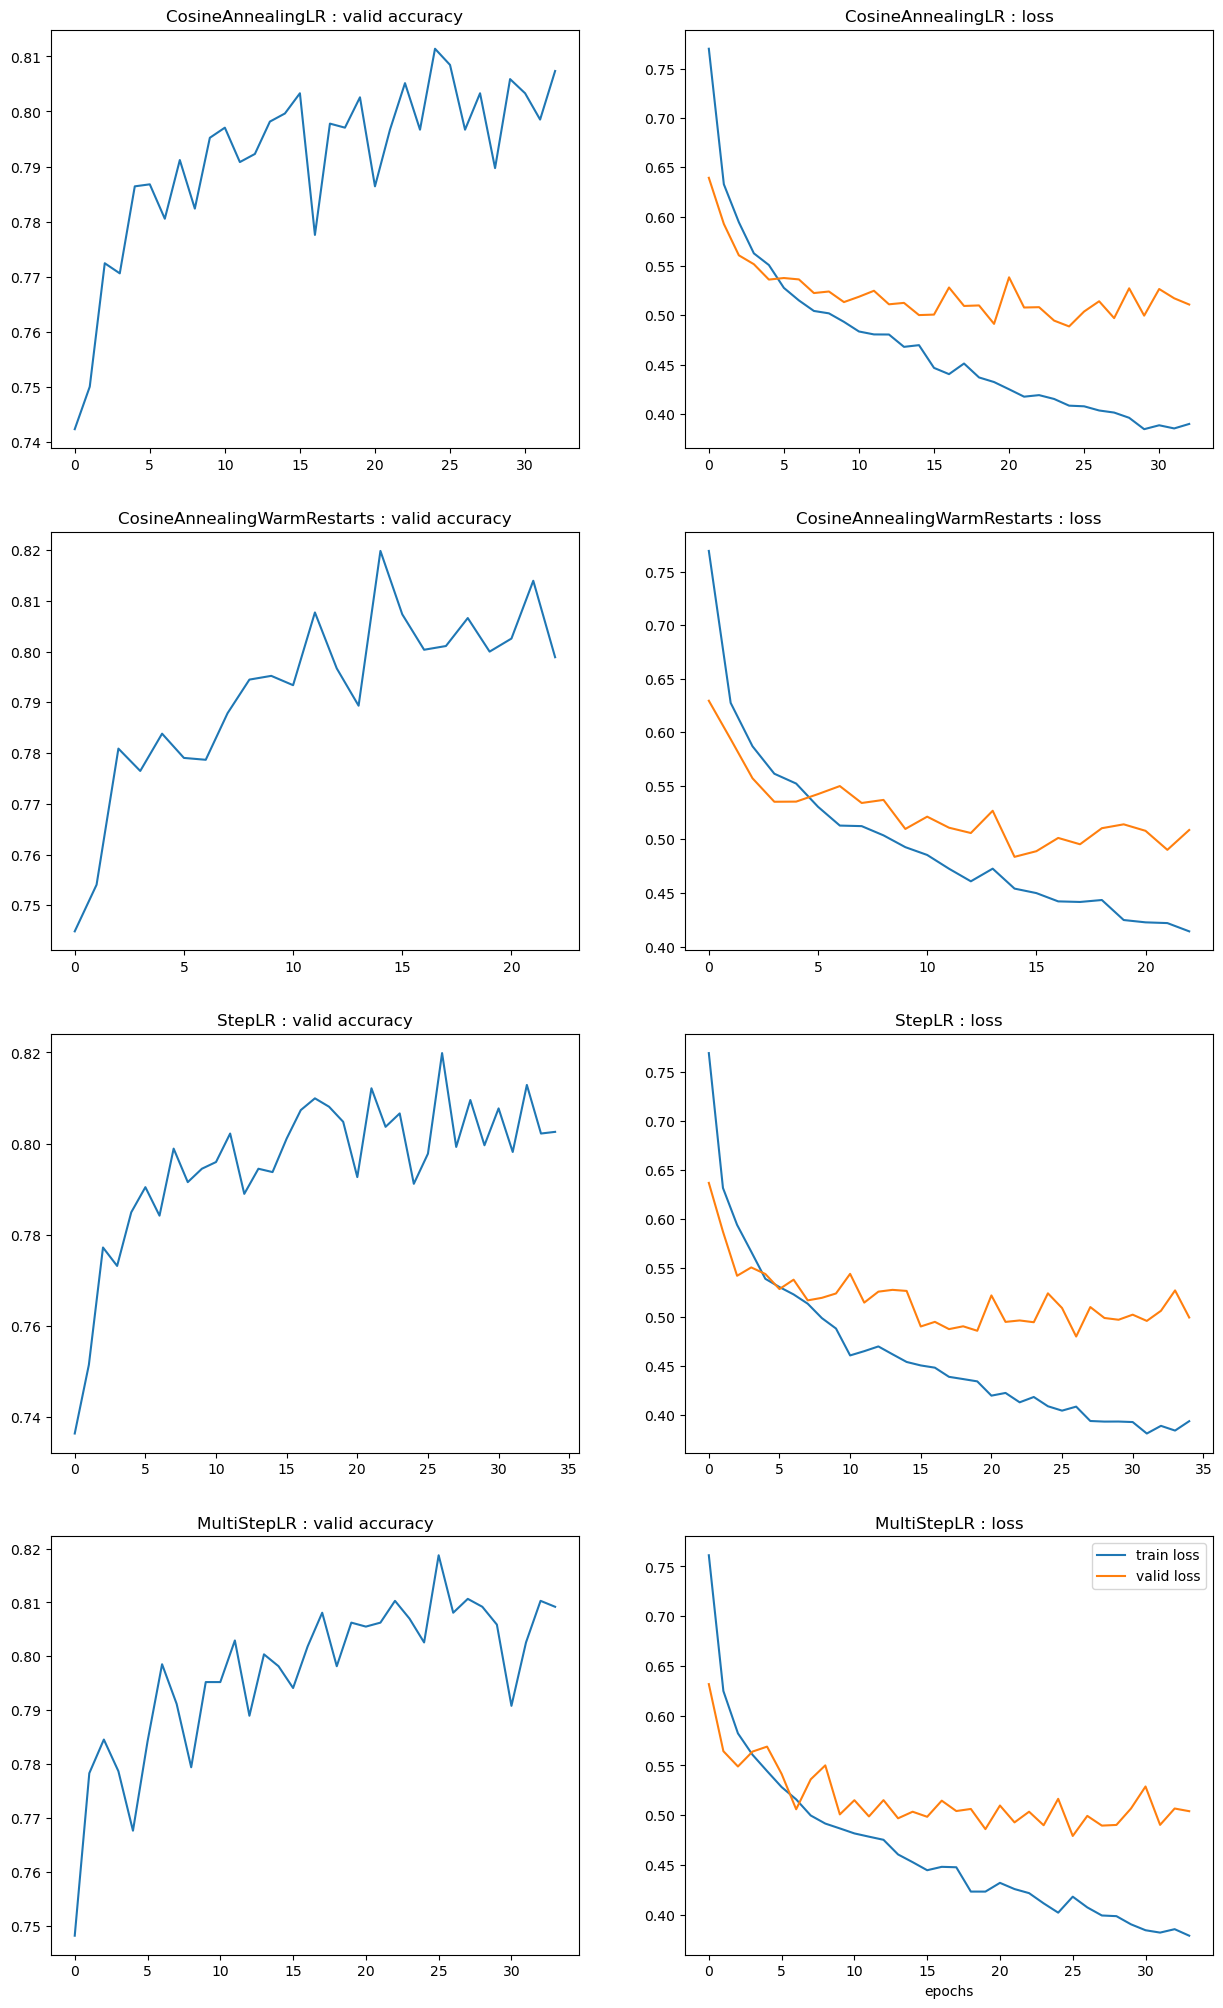

In [ ]:
# 그래프
fig, ax = plt.subplots(4,2, figsize=(15,25))

scheduler_name = {
    0 : "CosineAnnealingLR",
    1 : 'CosineAnnealingWarmRestarts',
    2 : 'StepLR',
    3 : 'MultiStepLR',
}

my_NN = {0 : myNN, 1 : myNN5, 2 : myNN3, 3 : myNN4}

for i in range(4):
    x = np.arange(len(my_NN[i].valid_acc_li))
    ax[i][0].plot(x, my_NN[i].valid_acc_li, label='valid_accuracy')
    ax[i][0].set_title(f'{scheduler_name[i]} : valid accuracy')
    ax[i][1].plot(x, my_NN[i].train_loss_li, label='train loss')
    ax[i][1].plot(x, my_NN[i].valid_loss_li, label='valid loss')
    ax[i][1].set_title(f'{scheduler_name[i]} : loss')
    plt.xlabel('epochs')
    plt.legend(loc='best')

In [ ]:
myNN_df = pd.DataFrame({
    "myNN_valid_acc" : myNN.valid_acc_li,
    "myNN_valid_loss" : myNN.valid_loss_li,
    "myNN_train_loss" : myNN.train_loss_li,
})
myNN5_df = pd.DataFrame({
    "myNN5_valid_acc" : myNN5.valid_acc_li,
    "myNN5_valid_loss" : myNN5.valid_loss_li,
    "myNN5_train_loss" : myNN5.train_loss_li,
})
myNN3_df = pd.DataFrame({
    "myNN3_valid_acc" : myNN3.valid_acc_li,
    "myNN3_valid_loss" : myNN3.valid_loss_li,
    "myNN3_train_loss" : myNN3.train_loss_li,
})
myNN4_df = pd.DataFrame({
    "myNN4_valid_acc" : myNN4.valid_acc_li,
    "myNN4_valid_loss" : myNN4.valid_loss_li,
    "myNN4_train_loss" : myNN4.train_loss_li,
})
myNN_df2 = pd.concat([myNN_df,myNN5_df,myNN3_df,myNN4_df], ignore_index=True, axis=1)
myNN_df2

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.742279,0.639345,0.770098,0.744853,0.629393,0.769224,0.736397,0.636522,0.768996,0.748162,0.631777,0.761249
1,0.750000,0.592637,0.632799,0.754044,0.593554,0.627397,0.751471,0.586780,0.631355,0.778309,0.564382,0.624814
2,0.772426,0.560812,0.594337,0.780882,0.557008,0.586888,0.777206,0.541703,0.593687,0.784559,0.549017,0.582262
3,0.770588,0.551810,0.562795,0.776471,0.535101,0.561258,0.773162,0.550233,0.566354,0.778676,0.563963,0.560800
4,0.786397,0.536249,0.550978,0.783824,0.535231,0.552080,0.784926,0.543530,0.538615,0.767647,0.568976,0.544382
5,0.786765,0.537806,0.527808,0.779044,0.542253,0.530421,0.790441,0.528154,0.530200,0.784191,0.541562,0.528332
6,0.780515,0.536411,0.515118,0.778676,0.549739,0.512869,0.784191,0.537716,0.522675,0.798529,0.506013,0.515952
7,0.791176,0.522585,0.504443,0.787868,0.533958,0.512355,0.798897,0.516612,0.513197,0.791176,0.536107,0.499768
8,0.782353,0.524154,0.502018,0.794485,0.536821,0.503731,0.791544,0.519195,0.498520,0.779412,0.550128,0.491649
9,0.795221,0.513435,0.493420,0.795221,0.509727,0.492726,0.794485,0.523645,0.487888,0.795221,0.500862,0.486775


In [ ]:
myNN.valid_acc_li

[0.7422794117647059,
 0.75,
 0.7724264705882353,
 0.7705882352941177,
 0.7863970588235294,
 0.7867647058823529,
 0.7805147058823529,
 0.7911764705882353,
 0.7823529411764706,
 0.7952205882352941,
 0.7970588235294118,
 0.7908088235294117,
 0.7922794117647058,
 0.7981617647058824,
 0.7996323529411765,
 0.8033088235294118,
 0.7775735294117647,
 0.7977941176470589,
 0.7970588235294118,
 0.8025735294117647,
 0.7863970588235294,
 0.7966911764705882,
 0.8051470588235294,
 0.7966911764705882,
 0.8113970588235294,
 0.8084558823529412,
 0.7966911764705882,
 0.8033088235294118,
 0.7897058823529411,
 0.8058823529411765,
 0.8033088235294118,
 0.7985294117647059,
 0.8073529411764706]

In [ ]:
myNN.train_loss_li

[0.7700980527361992,
 0.6327985842643706,
 0.5943374760469234,
 0.5627954011067383,
 0.5509783466440455,
 0.5278078375297931,
 0.5151175291401814,
 0.5044425713756104,
 0.5020176683037417,
 0.4934202095224682,
 0.4836497984887469,
 0.4806738804406626,
 0.48057898440542923,
 0.46808026998991537,
 0.4697915770377385,
 0.4467674896567654,
 0.4404331563441565,
 0.45118815790892297,
 0.43708716694275757,
 0.4324311710264767,
 0.4251091763255382,
 0.4176035665117752,
 0.4191673878752893,
 0.4152905446063595,
 0.4085014939145756,
 0.40784528636315215,
 0.40361365237417923,
 0.4015074855462732,
 0.396205809200817,
 0.3846721030386007,
 0.38862785498030505,
 0.38542748273068617,
 0.3899766096505222]

In [ ]:
myNN.valid_loss_li

[0.6393448657849256,
 0.5926371837363523,
 0.5608120206524344,
 0.5518102786120247,
 0.5362493546570049,
 0.5378062032601413,
 0.5364108341581681,
 0.5225846197675256,
 0.5241542716236676,
 0.5134353036389632,
 0.5188347469357883,
 0.524901831150055,
 0.5111867981798509,
 0.5126224221552119,
 0.5002630884156508,
 0.5007537603378296,
 0.5282028746955535,
 0.5095146485987831,
 0.5100373359287487,
 0.49135334070991066,
 0.5385244990096373,
 0.5079470343449537,
 0.5082696546526516,
 0.4946774652775596,
 0.4887731299680822,
 0.5038888482486501,
 0.5142621859031565,
 0.4971880486782859,
 0.5273865945198957,
 0.49970228514250586,
 0.5266823123483096,
 0.5172824180301498,
 0.5109530746936798]

In [4]:
class mySplitFP():
    def __init__(self, root, labels_map):
        self.root, self.labels_map = root, labels_map
        self.dfs = None
        
    def __call__(self):
        return self.split_join_dfs()
        
    def create_dfs(self):
        cloudy_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[0]+'/*.*'), 'label':0})
        foggy_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[1]+'/*.*'), 'label':1})
        rainy_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[2]+'/*.*'), 'label':2})
        snowy_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[3]+'/*.*'), 'label':3})
        sunny_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[4]+'/*.*'), 'label':4})
        self.dfs = [cloudy_df, foggy_df, rainy_df, snowy_df, sunny_df]
        
    def split_join_dfs(self, train_p=0.65, valid_p=0.15, test_p=0.2):
        self.create_dfs()
        idxs_dict = {'train':[], 'valid':[], 'test':[]}
        for df in self.dfs:
            train_n, valid_n = len(df)//(1/train_p), len(df)//(1/valid_p)
            df['cut'] = pd.cut(df.index, bins=[-np.inf, train_n, train_n+valid_n, np.inf], labels=['train','valid','test'])
            for k in idxs_dict.keys():
                idxs_dict[k].append(df.loc[df['cut']==k, ['filepath','label']])
        for k,v in idxs_dict.items():
            if k=='train': train_df = pd.concat(v, axis=0).reset_index()
            elif k=='valid': valid_df = pd.concat(v, axis=0).reset_index()
            elif k=='test': test_df = pd.concat(v, axis=0).reset_index()
        return train_df, valid_df, test_df
    
    def split_join_dfs_fail(self):
        self.create_dfs()
        idxs_dict = {'train':[], 'valid':[], 'test':[]}
        for df in self.dfs:
            train_idxs, test_idxs = train_test_split(df.index, test_size=0.2, shuffle=True)
            train_idxs, valid_idxs = train_test_split(train_idxs, test_size=0.2, shuffle=True)
            for k,idxs in zip(idxs_dict.keys(),[train_idxs,valid_idxs,test_idxs]):
                idxs_dict[k].append(idxs)
        for k in idxs_dict.keys():
            each_dfs = [self.dfs[i].iloc[idxs_dict[k][i]] for i in range(len(self.dfs))]
            if k=='train': train_df = pd.concat(each_dfs, axis=0).reset_index()
            elif k=='valid': valid_df = pd.concat(each_dfs, axis=0).reset_index()
            elif k=='test': test_df = pd.concat(each_dfs, axis=0).reset_index()
        return train_df, valid_df, test_df
    
class mycreateDataset(Dataset):
    def __init__(self, df, transform, using='transforms'):
        self.filepaths = df['filepath'].values
        self.labels = df['label'].values
        self.transform = transform
        self.using = using

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_filepath = self.filepaths[idx]
        img = Image.open(img_filepath).convert('RGB')
        if self.using=='A': 
            img = np.array(img)
            transformed_img = self.transform(image=img)['image']
        else: 
            transformed_img = self.transform(img)
        return transformed_img, self.labels[idx]

class mysetting():
    def __init__(self, root, labels_map):
        self.labels_map = labels_map
        self.train_df, self.valid_df, self.test_df = mySplitFP(root, labels_map).__call__()
        
    def getDataset(self, transform, using='transforms'):
        self.trainset = mycreateDataset(self.train_df, transform, using)
        self.validset = mycreateDataset(self.valid_df, transform, using)
        self.testset = mycreateDataset(self.test_df, transform, using)
        print('train, valid, test:', len(self.trainset), len(self.validset), len(self.testset))
        return self
    
    def getDataloader(self, batch_s=16):
        self.trainloader = DataLoader(self.trainset, batch_size=batch_s, shuffle=True)
        self.validloader = DataLoader(self.validset, batch_size=batch_s, shuffle=True)
        self.testloader = DataLoader(self.testset, batch_size=batch_s, shuffle=True)
        print('train, valid, test:', len(self.trainloader), len(self.validloader), len(self.testloader))
        train_iter = iter(self.trainloader)
        imgs, labels = train_iter.__next__()
        print('trainloader shape', imgs.shape, labels.shape)
        return self
    
    def showimg(self):
        fig, ax = plt.subplots(4,8, figsize=(14,8))
        ax = ax.flatten()
        for i in range(32):
            item = self.trainset[np.random.randint(0, len(self.trainset))]
            img, label = item[0].permute(1,2,0), item[1]
            img.mul_(torch.tensor([0.229, 0.224, 0.225])) # std
            img.add_(torch.tensor([0.485, 0.456, 0.406])) # mean
            ax[i].axis('off'); ax[i].imshow(img)
            ax[i].set_title(self.labels_map[label])

In [5]:
class train():
    def __init__(self, model, loss_fn, optimizer, trainloader, validloader, testloader, 
                 scheduler, device, epochs=30, patience=5, batch_s=16, reg=False,
                 cnn=True, resize=784):
        self.model, self.loss_fn, self.optimizer = model, loss_fn, optimizer
        self.trainloader, self.validloader, self.testloader = trainloader, validloader, testloader
        self.scheduler, self.device = scheduler, device
        self.epochs, self.patience, self.batch_s = epochs, patience, batch_s
        self.reg = reg
        self.cnn, self.resize = cnn, resize
        self.train_loss_li, self.valid_loss_li, self.valid_acc_li = [], [], []
        
    def train_loop(self):
        min_loss = 2000; trigger = 0
        train_loss_li, valid_loss_li, valid_acc_li = [], [], []
        for epoch in range(self.epochs):
            self.model.train() # 훈련모드
            train_loss = 0
            for imgs, labels in self.trainloader:
                if self.cnn:
                    imgs, labels = imgs.to(self.device), labels.to(self.device)
                else:
                    imgs.resize_(imgs.shape[0], self.resize)
                loss = self.loss_fn(self.model(imgs), labels) 
                self.optimizer.zero_grad() 
                loss.backward() 
                self.optimizer.step() 
                train_loss += loss.item()

            self.model.eval() # 평가 모드
            valid_loss, valid_accuracy = self.evaluate(valid=True)

            if not self.reg: print('Epoch : {}/{}.......'.format(epoch+1, self.epochs),            
                  'Train Loss : {:.3f}'.format(train_loss/len(self.trainloader)), 
                  'Valid Loss : {:.3f}'.format(valid_loss), 
                  'Valid Accuracy : {:.3f}'.format(valid_accuracy))
            else: print('Epoch : {}/{}.......'.format(epoch+1, self.epochs),            
                  'Train Loss : {:.3f}'.format(train_loss/len(self.trainloader)), 
                  'Valid Loss : {:.3f}'.format(valid_loss))
            train_loss_li.append(train_loss/len(self.trainloader))
            valid_loss_li.append(valid_loss)
            valid_acc_li.append(valid_accuracy)

            if valid_loss > min_loss: # early stop
                trigger += 1
                if trigger > self.patience:
                    print('\nEarly Stopping!! epoch/epochs: {}/{}'.format(epoch, self.epochs))
                    break
            else:
                trigger = 0
                min_loss = valid_loss # min_loss 갱신
                best_model_state = deepcopy(self.model.state_dict())
                torch.save(best_model_state, 'best_checkpoint.pth') # valid loss가 커지기 전의 모델 저장

            self.scheduler.step(valid_loss) # learning rate scheduler
        self.train_loss_li, self.valid_loss_li, self.valid_acc_li = train_loss_li, valid_loss_li, valid_acc_li
        return

    def result_plot(self):
        fig, ax = plt.subplots(1,2, figsize=(10,3))
        x = np.arange(len(self.valid_acc_li))
        ax[0].plot(x, self.valid_acc_li, label='valid_accuracy')
        ax[0].set_title('valid accuracy')
        ax[1].plot(x, self.train_loss_li, label='train loss')
        ax[1].plot(x, self.valid_loss_li, label='valid loss')
        ax[1].set_title('loss')
        plt.xlabel('epochs'); plt.legend(loc='best')
        plt.show()

    def evaluate(self, valid=False):
        if valid: load = self.validloader
        else: load = self.testloader
            
        loss, accuracy = 0, 0
        with torch.no_grad():
            for imgs, labels in load:
                if self.cnn:
                    imgs, labels = imgs.to(self.device), labels.to(self.device)
                else:
                    imgs.resize_(imgs.size()[0], self.resize)
                logit = self.model(imgs)
                _, preds = torch.max(logit, 1)
                loss += self.loss_fn(logit, labels).item()
                accuracy += int((preds==labels).sum())
        return loss/len(load), accuracy/(self.batch_s*len(load))
    
    def check(self, unsq=True, rnd_idx=10):
        test_iter = iter(self.testloader)
        imgs, labels = next(test_iter)
        print(imgs.size(), labels.size())
        print(imgs[rnd_idx].shape, labels[rnd_idx])
        self.model.eval()
        with torch.no_grad():
            if unsq:
                logit = self.model(imgs[rnd_idx].unsqueeze(0))
            else:
                logit = self.model(imgs[rnd_idx].view(1, self.resize))
        pred = logit.max(dim=1)[1]
        print(pred==labels[rnd_idx])
        
    def evaluation(self, model, testloader, loss_fn):
        loss, accuracy = 0, 0
        with torch.no_grad():
            for imgs, labels in testloader:
                if self.cnn:
                    imgs, labels = imgs.to(self.device), labels.to(self.device)
                else:
                    imgs.resize_(imgs.size()[0], self.resize)
                logit = model(imgs)
                _, preds = torch.max(logit, 1)
                loss += loss_fn(logit, labels).item()
                accuracy += int((preds==labels).sum())
        print('test loss: {:.3f}\ntest accuracy: {:.3f}'.format(loss/len(testloader), accuracy/(self.batch_s*len(testloader))))

    def load_model(self, dirct, model):
        state_dict = torch.load(dirct)
        load_model = model
        load_model.load_state_dict(state_dict)
        load_model.eval()
        self.evaluation(load_model, self.testloader, self.loss_fn)

In [6]:
# # 현재 모델에 저장되어 있는 모델 파라미터
# model.state_dict().keys()

# torch.save(model.state_dict(), 'last_checkpoint.pth')

# # 시간이 흐른뒤 다시 모델 가져오기
# last_state_dict = torch.load('last_checkpoint.pth')

# last_state_dict.keys()

# # 읽어들인 모델 파라미터는 모델 아키텍처에 연결을 시켜줘야 함
# # load_state_dict() 사용
# last_model = model
# last_model.to(device)
# last_model.load_state_dict(last_state_dict)

# last_model.eval()
# evaluation(last_model, testloader, loss_fn)  

# # valid loss or accuracy 기준 best model
# best_state_dict = torch.load('best_checkpoint.pth')
# best_model = model
# best_model.to(device)
# best_model.load_state_dict(best_state_dict)

# best_model.eval()
# evaluation(best_model, testloader, loss_fn)

# #best_state_dict['conv_block1.0.weight']

# #last_state_dict['conv_block1.0.weight']